In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from PIL import Image

import tensorflow as tf
from tensorflow import keras, einsum
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
import tensorflow.keras.layers as nn
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from einops import rearrange
from einops.layers.tensorflow import Rearrange
from functools import partial
from inspect import isfunction
from DataMaker import *

keras.backend.set_image_data_format('channels_first')

2024-01-06 23:03:32.693796: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 23:03:33.365278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-01-06 23:03:35.337470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-06 23:03:35.479842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-06 23:03:35.480116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
channels = 5
BATCH_SIZE = 32

TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_training.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_testing.hdf5'

gen_args = {
    'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'shuffle': False}

train_gen = HDF5ImageGenerator(TRAIN_PATH, mode = 'train', **gen_args)
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)

In [4]:
timesteps = 1000
learning_rate = 1e-5

# create a fixed beta schedule
beta = np.linspace(0.0001, 0.02, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)

# this function will help us set the RNG key for Numpy
def set_key(key):
    np.random.seed(key)

# this function will add noise to the input as per the given timestamp
def forward_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size=x_0.shape)
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(key, num):
    set_key(key)
    return tf.random.uniform(shape=[num], minval=0, maxval=timesteps, dtype=tf.int32)

In [5]:
# helpers functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# We will use this to convert timestamps to time encodings
class SinusoidalPosEmb(Layer):
    def __init__(self, dim, max_positions=10000):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim
        self.max_positions = max_positions

    def call(self, x, training=True):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]

        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)

        return emb
        
# small helper modules
class Identity(Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def call(self, x, training=True):
        return tf.identity(x)


class Residual(Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x, training=True):
        return self.fn(x, training=training) + x

def Upsample(dim):
    return nn.Conv2DTranspose(filters=dim, kernel_size=4, strides=2, padding='SAME')

def Downsample(dim):
    return nn.Conv2D(filters=dim, kernel_size=4, strides=2, padding='SAME')

class LayerNorm(Layer):
    def __init__(self, dim, eps=1e-5, **kwargs):
        super(LayerNorm, self).__init__(**kwargs)
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, dim, 1, 1]))
        self.b = tf.Variable(tf.zeros([1, dim, 1, 1]))

    def call(self, x, training=True):
        var = tf.math.reduce_variance(x, axis=1, keepdims=True)
        mean = tf.reduce_mean(x, axis=1, keepdims=True)

        x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
        return x
    
class LayerNormChannelsFirst(Layer):
    def __init__(self, dim, eps=1e-5, **kwargs):
        super(LayerNormChannelsFirst, self).__init__(**kwargs)
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, 1, 1, dim]))
        self.b = tf.Variable(tf.zeros([1, 1, 1, dim]))

    def call(self, x, training=True):
        var = tf.math.reduce_variance(x, axis=-1, keepdims=True)
        mean = tf.reduce_mean(x, axis=-1, keepdims=True)

        x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
        return x

class PreNorm(Layer):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def call(self, x, training=True):
        x = self.norm(x)
        return self.fn(x)

class SiLU(Layer):
    def __init__(self):
        super(SiLU, self).__init__()

    def call(self, x, training=True):
        return x * tf.nn.sigmoid(x)

def gelu(x, approximate=False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

class GELU(Layer):
    def __init__(self, approximate=False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training=True):
        return gelu(x, self.approximate)

In [6]:
# building block modules
class Block(Layer):
    def __init__(self, dim, groups=8):
        super(Block, self).__init__()
        self.proj = nn.Conv2D(dim, kernel_size=3, strides=1, padding='SAME')
        self.norm = tfa.layers.GroupNormalization(groups, epsilon=1e-05, axis=1)
        self.act = SiLU()


    def call(self, x, gamma_beta=None, training=True):
        x = self.proj(x)
        x = self.norm(x, training=training)

        if exists(gamma_beta):
            gamma, beta = gamma_beta
            x = x * (gamma + 1) + beta

        x = self.act(x)
        return x

class ResnetBlock(Layer):
    def __init__(self, dim, dim_out, time_emb_dim=None, groups=8):
        super(ResnetBlock, self).__init__()

        self.mlp = Sequential([
            SiLU(),
            nn.Dense(units=dim_out * 2)
        ]) if exists(time_emb_dim) else None

        self.block1 = Block(dim_out, groups=groups)
        self.block2 = Block(dim_out, groups=groups)
        self.res_conv = nn.Conv2D(filters=dim_out, kernel_size=1, strides=1) if dim != dim_out else Identity()

    def call(self, x, time_emb=None, training=True):
        gamma_beta = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            gamma_beta = tf.split(time_emb, num_or_size_splits=2, axis=1)

        h = self.block1(x, gamma_beta=gamma_beta, training=training)
        h = self.block2(h, training=training)

        return h + self.res_conv(x)

class LinearAttention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(LinearAttention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.attend = nn.Softmax()
        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False, data_format='channels_last')

        self.to_out = Sequential([
            nn.Conv2D(filters=dim, kernel_size=1, strides=1, data_format='channels_last'),
            LayerNormChannelsFirst(dim)
        ])

    def call(self, x, training=True):
        
        x = tf.transpose(x, [0, 2, 3, 1])
        
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)

        q = tf.nn.softmax(q, axis=-2)
        k = tf.nn.softmax(k, axis=-1)

        q = q * self.scale
        context = einsum('b h d n, b h e n -> b h d e', k, v)

        out = einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b x y (h c)', h=self.heads, x=h, y=w)
        out = self.to_out(out, training=training)

        out = tf.transpose(out, [0, 3, 1, 2])
        return out
    
class Attention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(Attention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False, data_format='channels_last')
        self.to_out = nn.Conv2D(filters=dim, kernel_size=1, strides=1, data_format='channels_last')

    def call(self, x, training=True):
        
        x = tf.transpose(x, [0, 2, 3, 1])
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)
        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        sim_max = tf.stop_gradient(tf.expand_dims(tf.argmax(sim, axis=-1), axis=-1))
        sim_max = tf.cast(sim_max, tf.float32)
        sim = sim - sim_max
        attn = tf.nn.softmax(sim, axis=-1)

        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b x y (h d)', x = h, y = w)
        out = self.to_out(out, training=training)
        
        out = tf.transpose(out, [0, 3, 1, 2])
        return out
    
class Conditioning(Layer):
    def __init__(self, res, num_channels=5):
        super().__init__()
        self.block = Sequential([
            nn.Dense(num_channels * res * res),
            SiLU(),
            nn.Reshape((num_channels, res, res))
        ])

        self.block.compile()

    def call(self, x):
        return self.block(x)

In [7]:
class Unet_conditional(Model):
    def __init__(self,
                 dim=64,
                 init_dim=None,
                 out_dim=None,
                 dim_mults=(1, 2, 4, 8),
                 channels=5,
                 resnet_block_groups=8,
                 learned_variance=False,
                 sinusoidal_cond_mlp=True,
                 in_res=64
                 ):
        super(Unet_conditional, self).__init__()

        # determine dimensions
        self.channels = channels
        self.in_res = in_res

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2D(filters=init_dim, kernel_size=7, strides=1, padding='SAME')

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        resnet_block_class = partial(ResnetBlock, groups = resnet_block_groups)
        
        # time embeddings
        time_dim = dim * 4
        self.sinusoidal_cond_mlp = sinusoidal_cond_mlp

        self.time_mlp = Sequential([
                SinusoidalPosEmb(dim),
                nn.Dense(units=time_dim),
                GELU(),
                nn.Dense(units=time_dim)
            ], name="time embeddings")

        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)

        now_res = in_res

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append([
                Conditioning(now_res),
                resnet_block_class(dim_in+1, dim_out, time_emb_dim=time_dim),
                resnet_block_class(dim_out, dim_out, time_emb_dim=time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else Identity()
            ])

            now_res //= 2 if not is_last else 1

        mid_dim = dims[-1]
        self.mid_conditioning = Conditioning(now_res)
        self.mid_block1 = resnet_block_class(mid_dim+1, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = resnet_block_class(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                Conditioning(now_res),
                resnet_block_class((dim_out * 2) + 1, dim_in, time_emb_dim=time_dim),
                resnet_block_class(dim_in, dim_in, time_emb_dim=time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else Identity()
            ])

            now_res *= 2 if not is_last else 1

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_conv = Sequential([
            resnet_block_class(dim * 2, dim),
            nn.Conv2D(filters=self.out_dim, kernel_size=1, strides=1)
        ], name="output")

    def call(self, x, time=None, redshift=None, training=True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)
        
        h = []

        for conditioning, block1, block2, attn, downsample in self.downs:
            cv = conditioning(redshift)
            x = tf.concat([x, cv], axis=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)
        
        cv = self.mid_conditioning(redshift)
        x = tf.concat([x, cv], axis=1)
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for conditioning, block1, block2, attn, upsample in self.ups:
            cv = conditioning(redshift)
            x = tf.concat([x, cv], axis=1)
            x = tf.concat([x, h.pop()], axis=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = tf.concat([x, h.pop()], axis=1)
        x = self.final_conv(x)
        return x

In [8]:
unet = Unet_conditional(
    in_res=64,
    channels=5
)

test_images = np.ones([1, 5, 64, 64])
test_timestamps = generate_timestamp(0, 1)
test_redshift = np.array([[1.0]])
k = unet(test_images, test_timestamps, test_redshift)
opt = keras.optimizers.Adam(learning_rate=learning_rate)

2024-01-06 23:03:36.420145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-01-06 23:03:36.572387: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-06 23:03:36.832449: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [9]:
def loss_fn(real, generated):
    loss = tf.math.reduce_mean((real - generated) ** 2)
    return loss

In [10]:
def train_step(batch, condition):
    rng, tsrng = np.random.randint(0, 100000, size=(2,))
    timestep_values = generate_timestamp(tsrng, batch.shape[0])

    noised_image, noise = forward_noise(rng, batch, tf.cast(timestep_values, tf.int32))
    with tf.GradientTape() as tape:
        prediction = unet(noised_image, timestep_values, condition)
        
        loss_value = loss_fn(noise, prediction)
    
    gradients = tape.gradient(loss_value, unet.trainable_variables)
    opt.apply_gradients(zip(gradients, unet.trainable_variables))

    return loss_value

In [11]:
epochs = 10
for e in range(1, epochs+1):
    bar = tf.keras.utils.Progbar(len(train_gen)-1)
    losses = []
    for i, batch in enumerate(iter(train_gen)):
        # run the training loop
        loss = train_step(batch[0], batch[1])
        losses.append(loss)
        bar.update(i, values=[("loss", loss)])  

    avg = np.mean(losses)
    print(f"Average loss for epoch {e}/{epochs}: {avg}")

2024-01-06 23:03:42.646135: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x1fb3aa80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-06 23:03:42.646160: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-06 23:03:42.664335: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-06 23:03:42.783371: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-06 23:03:42.841902: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6392/6392 [==============================] - 3410s 529ms/step - loss: 0.4372
Average loss for epoch 1/10: 0.43719562888145447
6392/6392 [==============================] - 3272s 512ms/step - loss: 0.0969
Average loss for epoch 2/10: 0.09690778702497482
6392/6392 [==============================] - 3259s 510ms/step - loss: 0.0813
Average loss for epoch 3/10: 0.08132949471473694
6392/6392 [==============================] - 3269s 511ms/step - loss: 0.0644
Average loss for epoch 4/10: 0.064423568546772
6392/6392 [==============================] - 3284s 514ms/step - loss: 0.0644
Average loss for epoch 5/10: 0.06441795080900192
6392/6392 [==============================] - 3285s 514ms/step - loss: 0.0608
Average loss for epoch 6/10: 0.060750897973775864
6392/6392 [==============================] - 3330s 521ms/step - loss: 0.0584
Average loss for epoch 7/10: 0.05835755169391632
6392/6392 [==============================] - 3389s 530ms/step - loss: 0.0581
Average loss for epoch 8/10: 0.05807890743

In [12]:
def save_gif(img_list, path="", interval=200):
    # Transform images from [-1,1] to [0, 255]
    imgs = []
    for im in img_list:
        im = np.array(im)
        max = np.amax(np.nan_to_num(img_list))
        min = np.amin(np.nan_to_num(img_list))
        im = (im - min) / (max - min) * 255
        im = np.clip(im, 0, 255).astype(np.int32)
        im = Image.fromarray(im)
        imgs.append(im)
    
    imgs = iter(imgs)

    # Extract first image from iterator
    img = next(imgs)

    # Append the other images and save as GIF
    img.save(fp=path, format='GIF', append_images=imgs,
             save_all=True, duration=interval, loop=0)

In [13]:
def ddpm(x_t, pred_noise, t):
    alpha_t = np.take(alpha, t)
    alpha_t_bar = np.take(alpha_bar, t)

    eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5
    mean = (1 / (alpha_t ** .5)) * (x_t - eps_coef * pred_noise)

    var = np.take(beta, t)
    z = np.random.normal(size=x_t.shape)

    return mean + (var ** .5) * z

In [14]:


def p_mean_variance(self, pred_noise, x, t, clip_denoised=True):
        x_recon = self.predict_start_from_noise(x, t=t, noise=pred_noise)
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t
        )
        return model_mean, posterior_variance, posterior_log_variance

def p_sample(pred_noise, x, t, clip_denoised=True):
        """Sample from the diffusion model.

        Args:
            pred_noise: Noise predicted by the diffusion model
            x: Samples at a given timestep for which the noise was predicted
            t: Current timestep
            clip_denoised (bool): Whether to clip the predicted noise
                within the specified range or not.
        """
        model_mean, _, model_log_variance = self.p_mean_variance(
            pred_noise, x=x, t=t, clip_denoised=clip_denoised
        )
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        # No noise when t == 0
        nonzero_mask = tf.reshape(
            1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1]
        )
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise

In [15]:
for k in range(0, 5):
    z = k / 2 + 0.1
    x = tf.random.normal((1, 5, 64, 64))

    img_list_g = []
    img_list_r = []
    img_list_i = []
    img_list_z = []
    img_list_y = []
    img_list_g.append(np.squeeze(x, 0)[0])
    img_list_r.append(np.squeeze(x, 0)[1])
    img_list_i.append(np.squeeze(x, 0)[2])
    img_list_z.append(np.squeeze(x, 0)[3])
    img_list_y.append(np.squeeze(x, 0)[4])
    
    for i in tqdm(range(timesteps - 1)):
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, np.array([z]), t)
        x = ddpm(x, pred_noise, t)
        img_list_g.append(np.squeeze(x, 0)[0])
        img_list_r.append(np.squeeze(x, 0)[1])
        img_list_i.append(np.squeeze(x, 0)[2])
        img_list_z.append(np.squeeze(x, 0)[3])
        img_list_y.append(np.squeeze(x, 0)[4])
            

    save_gif(img_list_g + ([img_list_g[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_g.gif", interval = 20)
    save_gif(img_list_r + ([img_list_r[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_r.gif", interval = 20)
    save_gif(img_list_i + ([img_list_i[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_i.gif", interval = 20)
    save_gif(img_list_z + ([img_list_z[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_z.gif", interval = 20)
    save_gif(img_list_y + ([img_list_y[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_y.gif", interval = 20)

100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


In [22]:
z = 10
x = tf.random.normal((1, 5, 64, 64))

img_list_g = []
img_list_r = []
img_list_i = []
img_list_z = []
img_list_y = []
img_list_g.append(np.squeeze(x, 0)[0])
img_list_r.append(np.squeeze(x, 0)[1])
img_list_i.append(np.squeeze(x, 0)[2])
img_list_z.append(np.squeeze(x, 0)[3])
img_list_y.append(np.squeeze(x, 0)[4])
    
for i in tqdm(range(timesteps - 1)):
    t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
    pred_noise = unet(x, np.array([z]), t)
    x = ddpm(x, pred_noise, t)
    img_list_g.append(np.squeeze(x, 0)[0])
    img_list_r.append(np.squeeze(x, 0)[1])
    img_list_i.append(np.squeeze(x, 0)[2])
    img_list_z.append(np.squeeze(x, 0)[3])
    img_list_y.append(np.squeeze(x, 0)[4])

100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


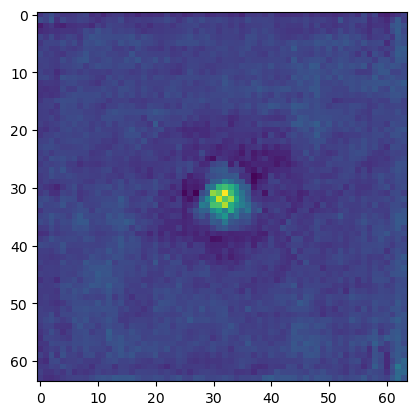

In [23]:
plt.imshow(img_list_g[999])

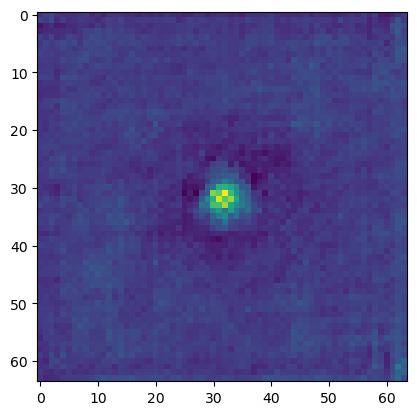

In [21]:
plt.imshow(img_list_g[999])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195


KeyboardInterrupt: 

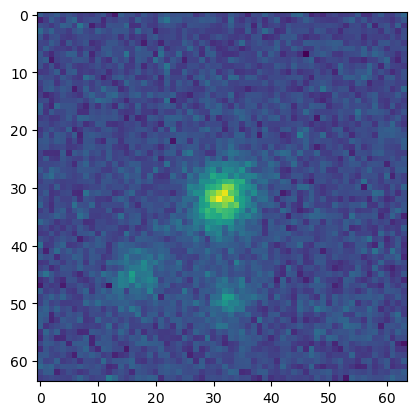

In [25]:
for i, batch in enumerate(iter(train_gen)):
    plt.imshow(batch[0][0][0])
    print(i)